# Lesson2g - Implementing Inception V3

## Setup

In [1]:
%matplotlib inline

from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam


import numpy as np

import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [3]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)
V3 = Model(input=base_model.input, output=predictions)

In [4]:
for layer in base_model.layers: layer.trainable = False

In [6]:
batch_size = 32

train_gen = image.ImageDataGenerator(horizontal_flip = True,
                               rotation_range = 30,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1, 
                               #preprocessing_function=preprocess_input
                                )


batches = train_gen.flow_from_directory("data/invasive/train", 
                                        target_size = (224, 224), 
                                        batch_size = batch_size, 
                                        )

valid_gen = image.ImageDataGenerator(#preprocessing_function = preprocess_input
                                    )

valid_batches = valid_gen.flow_from_directory("data/invasive/valid", 
                                              target_size = (224, 224), 
                                              batch_size = batch_size, 
                                              shuffle = False, 
                                             )

Found 2095 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## First try: Only training the last layer

In [6]:
V3.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
V3History = History()

V3History = V3.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 15, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([V3History,
                                                ModelCheckpoint('/home/ubuntu/INV-V32.model',
                                                                monitor='val_acc', 
                                                                save_best_only=True)
                                               ]))

Epoch 1/15
2095/2095 [==============================] - 98s - loss: 0.4610 - acc: 0.7652 - val_loss: 0.3992 - val_acc: 0.8050
Epoch 2/15
2095/2095 [==============================] - 78s - loss: 0.3404 - acc: 0.8487 - val_loss: 0.3969 - val_acc: 0.8150
Epoch 3/15
2095/2095 [==============================] - 81s - loss: 0.3347 - acc: 0.8482 - val_loss: 0.2949 - val_acc: 0.8900
Epoch 4/15
2095/2095 [==============================] - 79s - loss: 0.3221 - acc: 0.8616 - val_loss: 0.2786 - val_acc: 0.8850
Epoch 5/15
2095/2095 [==============================] - 79s - loss: 0.3070 - acc: 0.8616 - val_loss: 0.3276 - val_acc: 0.8800
Epoch 6/15
2095/2095 [==============================] - 79s - loss: 0.3073 - acc: 0.8606 - val_loss: 0.3255 - val_acc: 0.8600
Epoch 7/15
2095/2095 [==============================] - 76s - loss: 0.2832 - acc: 0.8735 - val_loss: 0.3172 - val_acc: 0.8700
Epoch 8/15
2095/2095 [==============================] - 81s - loss: 0.2902 - acc: 0.8768 - val_loss: 0.3968 - val_acc:

<function matplotlib.pyplot.show>

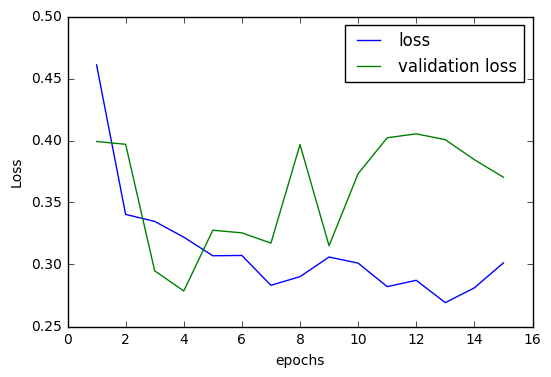

In [9]:
plt.plot(range(1, 16), V3History.history['loss'], label = 'loss')
plt.plot(range(1,16), V3History.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show

Not bad for a first run! But there's defintely plenty I can do to improve. Let's try training more layers

### Then, allowing up until the last convolutional block to be trained

In [2]:
V3 = load_model('/home/ubuntu/INV-V32.model')

In [3]:
for layer in V3.layers[:-24]: layer.trainable = False

In [4]:
V3.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

Without decreasing the learning rate, 

In [7]:
V3History1 = History()

V3History1 = V3.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 15, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([V3History1,
                                                ModelCheckpoint('/home/ubuntu/INV-V32.model',
                                                                monitor='val_acc', 
                                                                save_best_only=True)
                                               ]))

Epoch 1/15
2095/2095 [==============================] - 101s - loss: 0.2837 - acc: 0.8711 - val_loss: 0.3415 - val_acc: 0.8900
Epoch 2/15
2095/2095 [==============================] - 79s - loss: 0.2721 - acc: 0.8735 - val_loss: 0.3414 - val_acc: 0.8950
Epoch 3/15
2095/2095 [==============================] - 81s - loss: 0.2555 - acc: 0.8888 - val_loss: 0.3392 - val_acc: 0.9050
Epoch 4/15
2095/2095 [==============================] - 82s - loss: 0.2613 - acc: 0.8916 - val_loss: 0.3488 - val_acc: 0.9000
Epoch 5/15
2095/2095 [==============================] - 82s - loss: 0.2569 - acc: 0.8921 - val_loss: 0.3401 - val_acc: 0.9100
Epoch 6/15
2095/2095 [==============================] - 81s - loss: 0.2710 - acc: 0.8831 - val_loss: 0.3421 - val_acc: 0.9050
Epoch 7/15
2095/2095 [==============================] - 80s - loss: 0.2786 - acc: 0.8802 - val_loss: 0.3463 - val_acc: 0.8950
Epoch 8/15
2095/2095 [==============================] - 80s - loss: 0.2649 - acc: 0.8916 - val_loss: 0.3369 - val_acc

In [10]:
loss =  V3History1.history['loss']
val_loss = V3History1.history['val_loss']

<function matplotlib.pyplot.show>

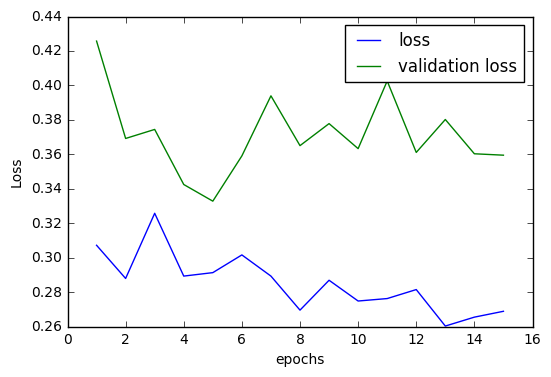

In [12]:
plt.plot(range(1, 16), loss, label = 'loss')
plt.plot(range(1,16), val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
#plt.axvline(x = 15, color = 'r')
plt.show